### Emotions - EDA, preparation and classification

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
import multiprocessing
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Basis-Dateipfad

def read_data(base_path):
    # Liste der Ordner mit Labels
    folders = [
        'angry',
        'disgust',
        'fear',
        'happy',
        'neutral',
        'sad',
        'surprise'
    ]

    # Initialisiere leere Listen für Bilder und Labels
    df=pd.DataFrame(columns=["images","labels"])

    # Iteriere durch die Ordner und sammle Bilder und Labels
    i=0
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        if os.path.exists(folder_path):
            image_files = os.listdir(folder_path)
            image_files.sort()
            for image_file in image_files:
                image_path = os.path.join(folder_path, image_file)
                # Öffne das Bild und speichere es im RGB-Format
                image = Image.open(image_path)#.convert('RGB')
                # Wandele das Bild in ein NumPy-Array um
                image=image.resize((128,128))
                image = np.array(image)
                df.loc[i,"images"]=image
                df.loc[i,"labels"]=folder
                i+=1

    return df


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = '../content/drive/MyDrive/ComputerVision/Data/Emotions/train'
test_path = '../content/drive/MyDrive/ComputerVision/Data/Emotions/validation'
train_df = read_data(train_path)
test_df=read_data(test_path)
df=pd.concat([train_df,test_df])

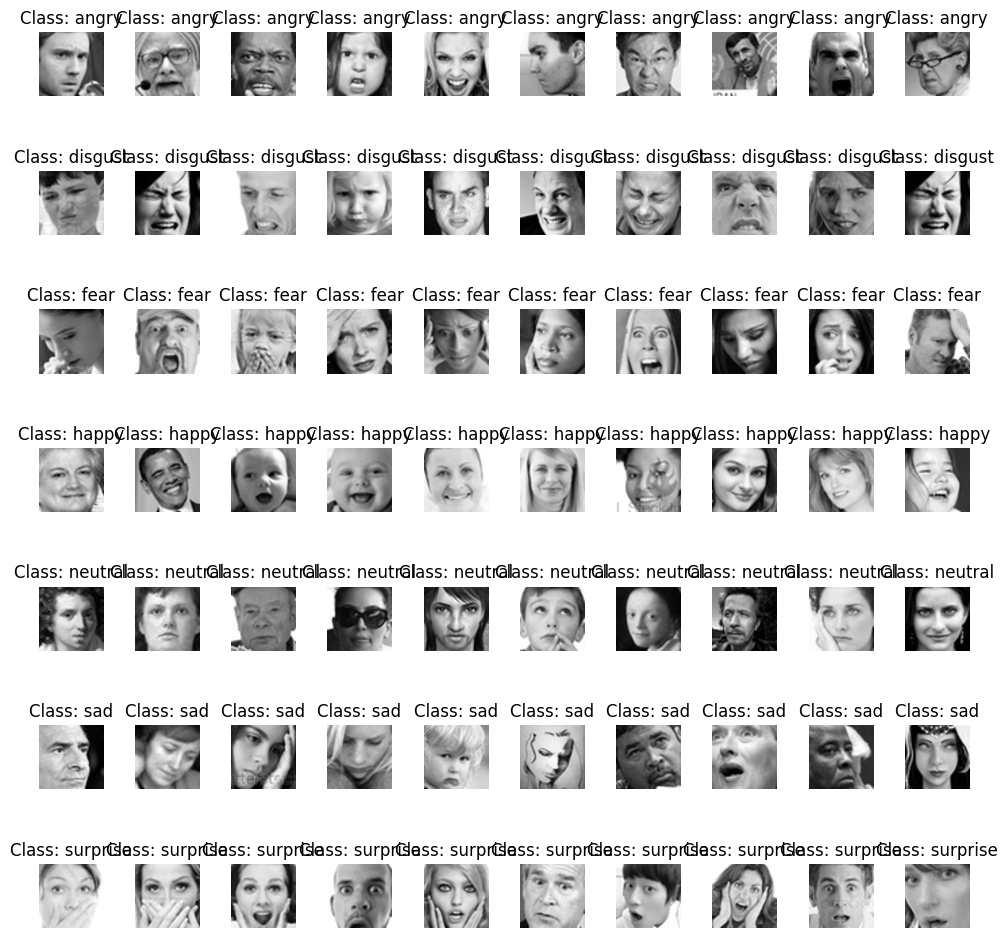

In [ ]:
classes_to_plot = 7
images_per_class = 10
fig, axs = plt.subplots(classes_to_plot, images_per_class, figsize=(12, 12))

for i, label in enumerate(df['labels'].unique()):
    class_data = df[df['labels'] == label].head(images_per_class)
    for j, (_, row) in enumerate(class_data.iterrows()):
        ax = axs[i, j]
        ax.imshow(row['images'], cmap='gray')
        ax.axis('off')
        ax.set_title(f'Class: {label}')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

<Axes: xlabel='labels'>

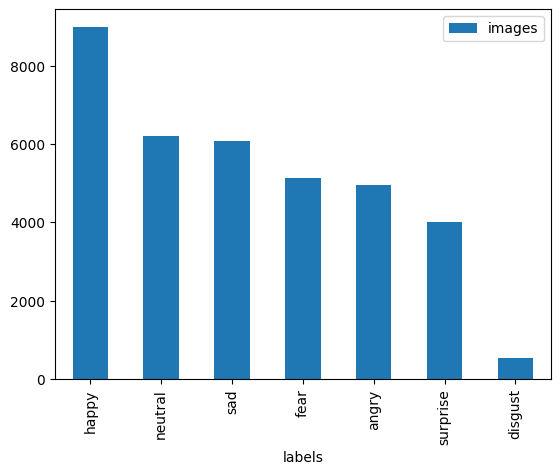

In [ ]:
df.groupby(["labels"]).count().sort_values("images",ascending=False).plot(kind="bar")

In [ ]:
df=df.sample(frac=1,random_state=0)
train,temp=train_test_split(df, test_size=0.3, random_state=0,shuffle=True,stratify=df["labels"])
val,test=train_test_split(temp, test_size=0.3, random_state=0,shuffle=True,stratify=temp["labels"])

In [ ]:
oversample=RandomOverSampler(sampling_strategy="auto",random_state=0)
X_over, y_over = oversample.fit_resample( train[["images"]], train[["labels"]])

In [ ]:
frames = [X_over, y_over]
train_oversampled = pd.concat(frames,axis=1)
train_oversampled =train_oversampled.sample(frac=1,random_state=0)


In [ ]:
train_oversampled

,images,labels
19959,"[[47, 48, 54, 61, 60, 53, 45, 39, 32, 29, 32, ...",fear
15414,"[[209, 205, 192, 177, 170, 171, 174, 175, 176,...",fear
2293,"[[27, 27, 28, 28, 28, 26, 24, 22, 20, 18, 16, ...",sad
41704,"[[189, 188, 184, 178, 171, 162, 156, 155, 158,...",surprise
8242,"[[3, 3, 1, 0, 2, 4, 13, 33, 62, 100, 158, 213,...",angry
...,...,...
30403,"[[69, 65, 55, 41, 30, 19, 12, 10, 12, 17, 24, ...",disgust
21243,"[[254, 254, 255, 255, 244, 215, 180, 146, 110,...",happy
42613,"[[160, 157, 149, 139, 138, 144, 152, 158, 165,...",surprise
43567,"[[148, 148, 147, 145, 145, 144, 145, 148, 150,...",surprise


<Axes: xlabel='labels'>

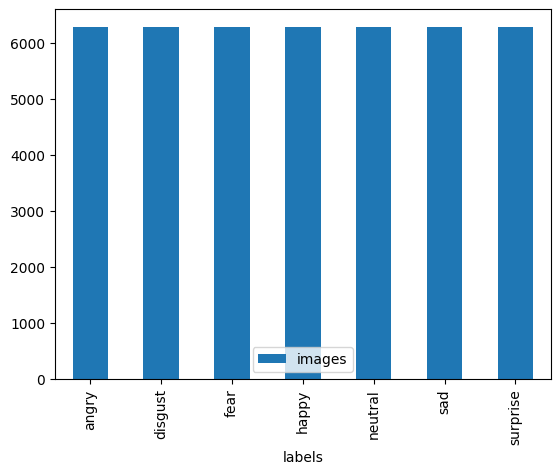

In [ ]:
 train_oversampled.groupby(["labels"]).count().sort_values("images",ascending=False).plot(kind="bar")

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)
validation_datagen = ImageDataGenerator(
      # rescale the pixel values (between 0 and 255) to the [0,1] interval
       rescale=1./255
)



In [ ]:
np.array(train_oversampled['labels'])

array(['fear', 'fear', 'sad', ..., 'surprise', 'surprise', 'angry'],
      dtype=object)

In [ ]:
# Schritt 1: "images" in einen NumPy ndarray umwandeln
X_train = np.array(train_oversampled['images'].tolist())

# Schritt 2: "labels" in einen NumPy ndarray umwandeln
y_train = np.array(train_oversampled['labels'])

# Überprüfung der Form der erstellten Arrays
print("Shape von X_train:", X_train.shape)
print("Shape von y_train:", y_train.shape)

Shape von X_train: (44044, 128, 128)
Shape von y_train: (44044,)


In [ ]:
train_oversampled['labels']

19959        fear
15414        fear
2293          sad
41704    surprise
8242        angry
           ...   
30403     disgust
21243       happy
42613    surprise
43567    surprise
2732        angry
Name: labels, Length: 44044, dtype: object

In [ ]:
mapping = {'angry':0,
    'disgust':1,
    'fear':2,
    'happy':3,
    'neutral':4,
    'sad':5,
    'surprise':6}
train_oversampled['labels'] = train_oversampled['labels'].map(mapping)
#X_train = np.array(train_oversampled['images'].tolist()
X_train_plot=np.expand_dims(X_train[10].reshape((1,) + X_train[1].shape), axis=-1)
X_train=np.stack(train_oversampled["images"].to_numpy())
#X_train = np.stack((X_train,) * 1, axis=-1)
X_train=np.expand_dims(X_train, axis=-1)
y_train=train_oversampled["labels"].values

In [ ]:
X_val=np.stack(val["images"].to_numpy())
#X_train = np.stack((X_train,) * 1, axis=-1)
X_val=np.expand_dims(X_val, axis=-1)
val["labels"]=val["labels"].map(mapping)
y_val=val["labels"].values

In [ ]:
X_test=np.stack(test["images"].to_numpy())
X_test=np.expand_dims(X_test, axis=-1)
test["labels"]=test["labels"].map(mapping)
y_test=test["labels"].values

In [ ]:
X_train_plot.shape

(1, 128, 128, 1)

In [ ]:
y_train_cat=to_categorical(y_train)
y_train_cat


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_val_cat=to_categorical(y_val)
y_val_cat

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_test_cat=to_categorical(y_test)
y_test_cat

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
batch_size = 8

train_iterator  = train_datagen.flow(X_train,  y_train_cat,
                                    batch_size=64)
validation_iterator = validation_datagen.flow(X_val,
                                              y_val_cat,
                                              batch_size=64)
test_iterator = test_datagen.flow(X_test,
                                              y_test_cat,
                                              batch_size=64)


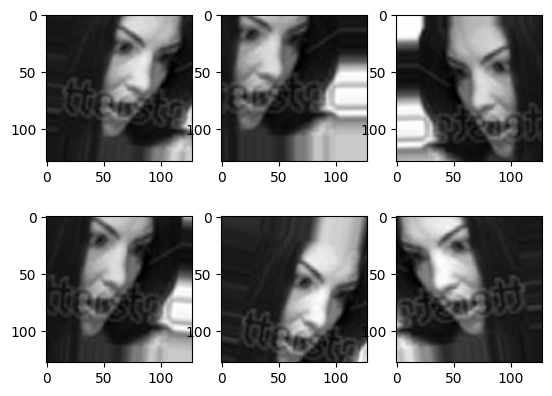

In [ ]:
def plotImages(x):
    i = 1
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(2,3,i)
        imgplot = plt.imshow(image.array_to_img(batch[0]),cmap='gray')
        i += 1
        if i % 7 == 0:
            break
    plt.show()

plotImages(X_train_plot)


In [ ]:
model = tf.keras.Sequential([  #Erstelle sequentielles Modell
    tf.keras.layers.Flatten(input_shape=(48,48,1)),  #Flatten Schicht #Sie wird verwendet, um die Eingabe in einen eindimensionalen Vektor umzuwandeln. Pixeln und 3 Farbkanälen (RGB) erwartet.
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(254, activation=tf.nn.relu),#Dense Schicht mit 512 Neuronen und ReLu-Aktivierung. ZUdem vollstndig verbunden (Jedes Neuron ist mit jedem Neuron der vorherigen Schicht verbunden)
    tf.keras.layers.Dense(128, activation=tf.nn.relu),#Dense Schicht mit 512 Neuronen und ReLu-Aktivierung. ZUdem vollstndig verbunden (Jedes Neuron ist mit jedem Neuron der vorherigen Schicht verbunden)
    tf.keras.layers.Dense(7,  activation=tf.nn.softmax) #Dense Schicht mit 10 Neuronen --> Anzahl der Klassen --> Softmax um W'keit der Klassen zu berechnen
])

In [ ]:
model = tf.keras.Sequential([
    # Convolutional layers
    tf.keras.layers.Conv2D(254, (3, 3),padding = 'same', activation='relu', input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3),padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3),padding = 'same', activation='relu'),

    # Fully connected layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(254, activation='relu'),
    tf.keras.layers.Dense(7,  activation=tf.nn.softmax)  # Output layer with 10 classes (CIFAR-10)
])

In [ ]:
metric_accuracy = tf.keras.metrics.CategoricalAccuracy('categorical_accuracy')
metric_precision = tf.keras.metrics.Precision()
metric_recall = tf.keras.metrics.Recall()

loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
              loss=loss,
              metrics=[metric_accuracy])

In [ ]:


early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=6,
            restore_best_weights=True
)

history = model.fit(
    train_iterator,
    epochs=25,
    batch_size=128,
    callbacks=[early_stopping],
    validation_data=validation_iterator  # Validation data
)


Epoch 1/25
689/689 [==============================] - 584s 847ms/step - loss: 1.7718 - categorical_accuracy: 0.2999 - val_loss: 1.6986 - val_categorical_accuracy: 0.3205
Epoch 2/25
689/689 [==============================] - 561s 814ms/step - loss: 1.5963 - categorical_accuracy: 0.3856 - val_loss: 1.4088 - val_categorical_accuracy: 0.4610
Epoch 3/25
689/689 [==============================] - 569s 825ms/step - loss: 1.4733 - categorical_accuracy: 0.4380 - val_loss: 1.4392 - val_categorical_accuracy: 0.4453
Epoch 4/25
689/689 [==============================] - 561s 814ms/step - loss: 1.3921 - categorical_accuracy: 0.4703 - val_loss: 1.3154 - val_categorical_accuracy: 0.4959
Epoch 5/25
689/689 [==============================] - 569s 825ms/step - loss: 1.3376 - categorical_accuracy: 0.4927 - val_loss: 1.2609 - val_categorical_accuracy: 0.5212
Epoch 6/25
689/689 [==============================] - 569s 826ms/step - loss: 1.2912 - categorical_accuracy: 0.5090 - val_loss: 1.2100 - val_categoric

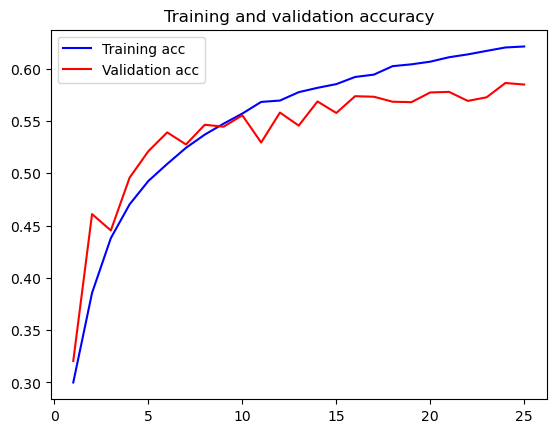

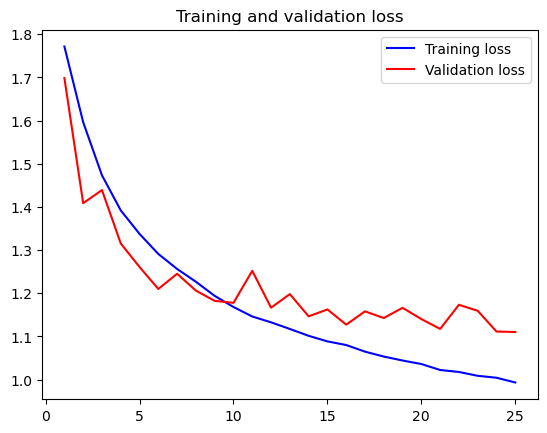

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model2 = tf.keras.Sequential([
    # Convolutional layers
    tf.keras.layers.Conv2D(254, (3, 3),padding = 'same', activation='relu', input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(512, (3, 3),padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(254, (3, 3),padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(512, (3, 3)),
    # Fully connected layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(254, activation='relu'),
    tf.keras.layers.Dense(7,  activation=tf.nn.softmax)  # Output layer with 10 classes (CIFAR-10)
])

In [ ]:
metric_accuracy = tf.keras.metrics.CategoricalAccuracy('categorical_accuracy')
metric_precision = tf.keras.metrics.Precision()
metric_recall = tf.keras.metrics.Recall()

loss = tf.keras.losses.CategoricalCrossentropy()
model2.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
              loss=loss,
              metrics=[metric_accuracy])

In [ ]:
num_threads = multiprocessing.cpu_count()
num_threads

8

In [ ]:
history =model2.fit(
    X_train, y_train_cat,
    epochs=20,
    batch_size=128,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val_cat),  # Validation data
    workers=num_threads,
    use_multiprocessing=True#,
)


Epoch 1/20
345/345 [==============================] - 1994s 6s/step - loss: 2.3423 - categorical_accuracy: 0.2506 - val_loss: 1.9213 - val_categorical_accuracy: 0.2365
Epoch 2/20
345/345 [==============================] - 1881s 5s/step - loss: 1.4209 - categorical_accuracy: 0.4557 - val_loss: 1.5052 - val_categorical_accuracy: 0.4179
Epoch 3/20
345/345 [==============================] - 1939s 6s/step - loss: 1.1364 - categorical_accuracy: 0.5689 - val_loss: 1.4182 - val_categorical_accuracy: 0.4765
Epoch 4/20
345/345 [==============================] - 1931s 6s/step - loss: 0.9897 - categorical_accuracy: 0.6302 - val_loss: 1.4082 - val_categorical_accuracy: 0.5027
Epoch 5/20
345/345 [==============================] - 1845s 5s/step - loss: 0.8730 - categorical_accuracy: 0.6759 - val_loss: 1.4602 - val_categorical_accuracy: 0.4902
Epoch 6/20
345/345 [==============================] - 1810s 5s/step - loss: 0.7649 - categorical_accuracy: 0.7193 - val_loss: 1.5758 - val_categorical_accuracy:

In [ ]:
model2.save("../Model/CNN.h5")

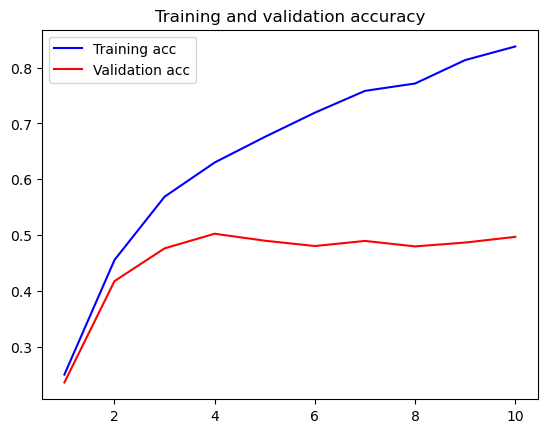

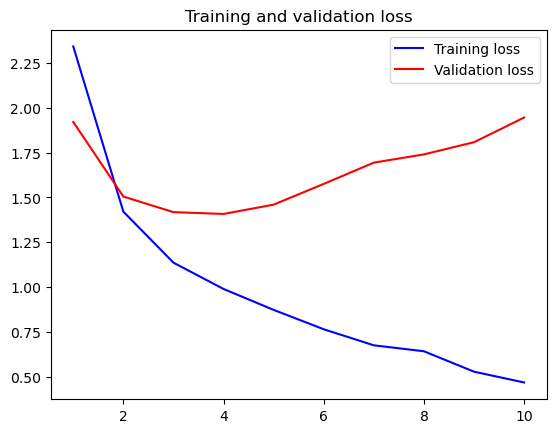

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model3 = tf.keras.Sequential([

    tf.keras.layers.Conv2D(254, (3,3), activation='relu',padding = 'same', input_shape=(48, 48, 1),kernel_regularizer=tf.keras.regularizers.l2(0.1)),
   tf.keras.layers.BatchNormalization(),
   # tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu' ,padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.BatchNormalization(),
 #   tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(512, (3,3), activation='relu',padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),



    tf.keras.layers.Conv2D(128, (3,3), activation='relu' ,padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.BatchNormalization(),
 #   tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512,kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(512,kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.35),

    tf.keras.layers.Dense(254,kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.35),

   # tf.keras.layers.Dense(128,kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Activation('relu'),
    #tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(7,  activation=tf.nn.softmax)  # Output layer with 10 classes (CIFAR-10)
])

metric_accuracy = tf.keras.metrics.CategoricalAccuracy('categorical_accuracy')
metric_precision = tf.keras.metrics.Precision()
metric_recall = tf.keras.metrics.Recall()

loss = tf.keras.losses.CategoricalCrossentropy()
model3.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
              loss=loss,
              metrics=[metric_accuracy])

In [ ]:
early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=6,
            restore_best_weights=True
)



history =model3.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val_cat),

)


Epoch 1/50
345/345 [==============================] - 38s 106ms/step - loss: 126.4703 - categorical_accuracy: 0.1619 - val_loss: 64.8145 - val_categorical_accuracy: 0.0279
Epoch 2/50
345/345 [==============================] - 36s 105ms/step - loss: 37.9794 - categorical_accuracy: 0.2012 - val_loss: 19.6052 - val_categorical_accuracy: 0.0890
Epoch 3/50
345/345 [==============================] - 36s 104ms/step - loss: 11.8647 - categorical_accuracy: 0.2900 - val_loss: 6.8012 - val_categorical_accuracy: 0.3161
Epoch 4/50
345/345 [==============================] - 36s 105ms/step - loss: 4.7416 - categorical_accuracy: 0.4276 - val_loss: 3.6248 - val_categorical_accuracy: 0.3814
Epoch 5/50
345/345 [==============================] - 36s 104ms/step - loss: 2.9348 - categorical_accuracy: 0.5142 - val_loss: 2.5838 - val_categorical_accuracy: 0.5126
Epoch 6/50
345/345 [==============================] - 36s 104ms/step - loss: 2.4052 - categorical_accuracy: 0.5478 - val_loss: 2.3051 - val_categoric

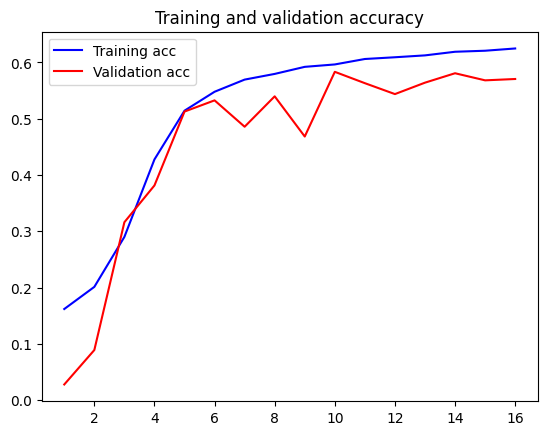

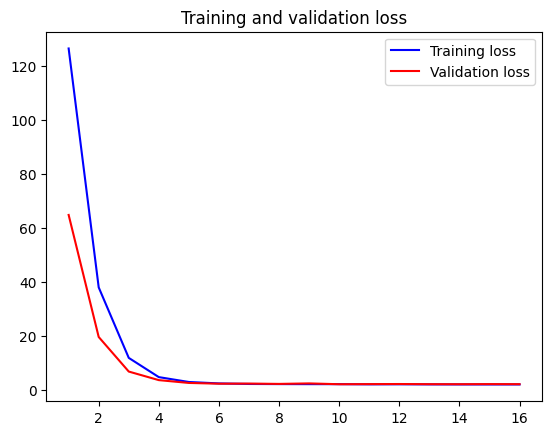

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model3.save("../content/drive/MyDrive/ComputerVision/Models/CNN_regularized.h5")

In [ ]:
model4 = tf.keras.Sequential([

    tf.keras.layers.Conv2D(254, (3,3), activation='relu',padding = 'same', input_shape=(128, 128, 1),kernel_regularizer=tf.keras.regularizers.l2(0.05)),
   tf.keras.layers.BatchNormalization(),
   # tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu' ,padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.BatchNormalization(),
 #   tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(512, (3,3), activation='relu',padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),



    tf.keras.layers.Conv2D(128, (3,3), activation='relu' ,padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.BatchNormalization(),
 #   tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512,kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(512,kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(254,kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(254,kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),


   # tf.keras.layers.Dense(128,kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Activation('relu'),
    #tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(7,  activation=tf.nn.softmax)  # Output layer with 10 classes (CIFAR-10)
])

metric_accuracy = tf.keras.metrics.CategoricalAccuracy('categorical_accuracy')
metric_precision = tf.keras.metrics.Precision()
metric_recall = tf.keras.metrics.Recall()

loss = tf.keras.losses.CategoricalCrossentropy()
model4.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
              loss=loss,
              metrics=[metric_accuracy])

In [ ]:
early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=6,
            restore_best_weights=True
)

history =model4.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val_cat),

)


Epoch 1/50
345/345 [==============================] - 69s 114ms/step - loss: 87.4960 - categorical_accuracy: 0.1897 - val_loss: 52.2722 - val_categorical_accuracy: 0.2646
Epoch 2/50
345/345 [==============================] - 37s 108ms/step - loss: 34.4821 - categorical_accuracy: 0.2760 - val_loss: 21.3646 - val_categorical_accuracy: 0.3218
Epoch 3/50
 17/345 [>.............................] - ETA: 34s - loss: 20.9608 - categorical_accuracy: 0.3516

KeyboardInterrupt: ignored

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model4.evaluate(X_val, y_val_cat)

236/236 [==============================] - 2s 9ms/step - loss: 2.2541 - categorical_accuracy: 0.5730


[2.254093647003174, 0.5729830265045166]

In [ ]:
predicted=np.argmax(model4.predict(X_test), axis=1)
predicted

101/101 [==============================] - 1s 7ms/step


array([4, 3, 3, ..., 0, 3, 4])

In [ ]:
remapping = {0:'angry',
    1:'disgust',
    2:'fear',
    3:'happy',
    4:'neutral',
    5:'sad',
    6:'surprise'}
predicted_remapped=pd.DataFrame(predicted)[0].map(remapping)
predicted_remapped

0       neutral
1         happy
2         happy
3         angry
4         angry
         ...   
3226        sad
3227    neutral
3228      angry
3229      happy
3230    neutral
Name: 0, Length: 3231, dtype: object

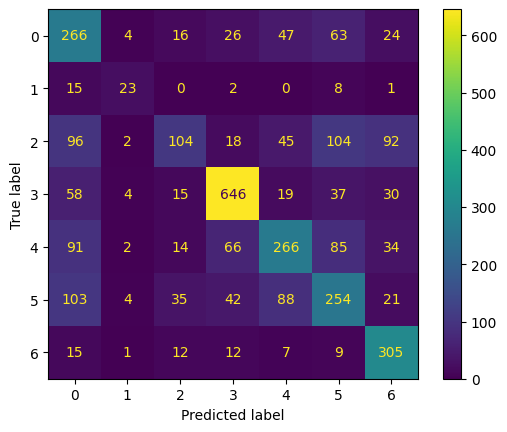

Accuracy: 0.5769111730114516
Recall: [0.59641256 0.46938776 0.22559653 0.79851669 0.47670251 0.46435101
 0.84487535]
Precision: [0.41304348 0.575      0.53061224 0.7955665  0.56355932 0.45357143
 0.60157791]
Precision: [0.48807339 0.51685393 0.31659056 0.79703886 0.51650485 0.45889792
 0.70276498]


In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,accuracy_score, recall_score, precision_score,f1_score

cm=confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ["negative[0]", "Positive[1]"])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, predicted,average=None)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, predicted,average=None)
print("Precision:", precision)

f1 = f1_score(y_test, predicted,average=None)
print("Precision:", f1)


In [ ]:
model4.save("../content/drive/MyDrive/ComputerVision/Models/CNN.h5")

In [ ]:
model4.evaluate(X_val, y_val_cat)